# Processing: Extracting Features from Atari Games

## Introduction
The goal of the project is to gather information on frames of a given game.
The two games chosen for this project are:
- Breakout: a simpler game used for simple testing of the processing algortihm
- Skiing: a game with more objects in order to test the processing in more complex use cases. 

The processing is composed of the following phases:
- Finding SIFT Keypoints
- Feature matching between frames
- Finding the connected components in the frames
- Classifying the objects we found as stationary or moving
- Track the movement of moving objects.

## Libraries
Now we import the necessary libraries. 
Let's have a rundown of each one and their purpose in this notebook:

- os: used for saving the frames in a directory.
- shutil: used for cleaning up previous frames for the chosen games.
- numpy: contains many useful function for dealing with frames.
- cv2: main library for image processing.
- matplotlib: useful for visualization of images and also plotting object tracking plots.

In [38]:
import os
import shutil
import numpy as np
import cv2 as cv
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # Set image size in notebook

## Utility functions
Now let's write down some useful functions for the whole project.

The first useful function to define is one to load frames and turn them grayscale.
The parameters are:
- game: the name of the game we want to load
- step: the number of frames skipped when loading them. The standard value is 100.

In [39]:
def load_frames(game, step = 100):
    """"Function that loads frames with a step given in step parameter 
    giving out images in colorscale and grayscale."""
    pth = f"../imgs/{game}"
    images = os.listdir(pth)
    imgs = []
    gray_imgs = []
    
    for i in range(0, len(images), step): # Load all frames in the folder
        image_path = os.path.join(pth, images[i])
        imgs.append(cv.imread(image_path))
        gray_imgs.append(cv.cvtColor(imgs[len(imgs) - 1], cv.COLOR_BGR2GRAY))

    return imgs, gray_imgs

show_images() function plots first max_im or less images given an image list.

In [40]:
def show_images(imgs, mode = None, max_im = 3):
    """"Function to show multiple images in a compact way."""
    num_imgs = min(max_im, len(imgs))
    _, ax = plt.subplots(ncols = num_imgs, figsize = (50,20))

    for i in range(num_imgs):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].grid(False)
        match mode:
            case 'rgb':
                ax[i].imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB))
            case 'gray':
                ax[i].imshow(imgs[i], cmap='gray')
            case _:
                ax[i].imshow(imgs[i])
        
    plt.tight_layout()

save_images() function is used for saving an image list into a given directory. This is useful if we want to save the results outside of the laboratory.

In [41]:
def save_images(dir_name, imgs):
    """Function to easily save the images."""
    path_to_dir = f'../imgs/{dir_name}/'

    if os.path.exists(path_to_dir):
        shutil.rmtree(path_to_dir)
    if not os.path.exists(path_to_dir):
        os.makedirs(path_to_dir)
        
    for i in range(0, len(imgs), 1):
        cv.imwrite(path_to_dir + 'frame' + str(i + 1) + '.png', imgs[i])


Another useful procedure to define is a function that reverses black and whites to have always a black background and white objects when searching for connected components and also thresholds the image to have more consistent white objects.

In [42]:
def reverse_and_highlight(gray_imgs, do_reverse= False, threshold = 60): 
    """Function to be used with white backgrounds in order to enhance the objects for analysis.
    With skiing adding this to the pipeline was necessary for a better result."""
    highlight_imgs = []
    for g in gray_imgs:
        highlight_imgs.append(g.copy())

    for i in range(len(highlight_imgs)):
        if do_reverse:
            highlight_imgs[i] = 255 - highlight_imgs[i] # Reverse black and white values
        #we are doing an incorrect type assigment next
        _, highlight_imgs[i] = cv.threshold(highlight_imgs[i],threshold,255,cv.THRESH_BINARY)

    return highlight_imgs

## Step 1: SIFT Keypoints
The first step is to identify SIFT keypoints in the image and finding the descript. In this step, using the built-in cv2 functions we define a procedure to extract them given the frames returning the result.

In [43]:
def finding_SIFT(gray_imgs):
    """Function to find keypoints in the frames saving them with the descriptors."""
    # Create a SIFT object
    sift = cv.SIFT_create()
    kps = [] # List to collect keypoints
    des = [] # List to collect descriptors

    for g in gray_imgs:
        kp, de = sift.detectAndCompute(g,None)
        kps.append(kp)
        des.append(de)
    dict_kps_des = {'kps': kps, 'des': des} # Save kps and des into a sigle object

    # Now we can draw the keypoints on the frames themeselves.
    kp_imgs = []
    for i in range(len(kps)):
        kp_imgs.append(cv.drawKeypoints(gray_imgs[i], kps[i], gray_imgs[i].copy(),
                                         flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    return dict_kps_des, kp_imgs

## Step 2: Feature Matching
Now we will match the keypoints found in the previous step from one frame to another. Let us use the built-in cv2 functions with homography to enhance matching. 

In [44]:
def match_frames(im1, im2, kp1, kp2, de1, de2, MIN_MATCH_COUNT = 10):
    """"Function to find matches between two successive frames."""
    # Prepare the matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(de1, de2, k = 2)
    
    # Store all the good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)
    
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 1, 2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 1, 2)
    
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
    
        h,w = im1.shape
        pts = np.float32([ [0, 0], [0, h - 1], [w - 1, h - 1],[w - 1, 0] ]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)
    
        im2 = cv.polylines(im2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
    
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor = (0,255,0), # Draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # Draw only inliers
                    flags = 2)
    
    im3 = cv.drawMatches(im1,kp1,im2,kp2,good,None,**draw_params)

    return good, im3

Now let's wrap the previous function in order to perform the matching for all frames.

In [45]:
def find_all_matches(gray_imgs, kps, des):
    # Let us now execute the above code
    good_matches = []
    matched_images = []
    for i in range(len(des) - 1):
        gd, im3 = match_frames(gray_imgs[i], gray_imgs[i + 1], kps[i], kps[i + 1], des[i], des[i + 1])
        good_matches.append(gd)
        matched_images.append(im3)
    return good_matches, matched_images

## Step 3: Find Connected Components
Now we will find connected components in the frames using cv2 functions and saving various information on the components found:
- num_labels: number of components found in a given frame.
- labels: an array with an image for each frame with the different labels for each component.
- stats: some information for each component in a given frame. They are coordinates, width, high and area.
- centroids: centroids for each component in a given frame.

In [46]:
def find_conn(gray_imgs):
    thresholded = []
    for i in gray_imgs:
        _, thresh = cv.threshold(i, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
        thresholded.append(thresh)

    num_labels = []
    labels = []
    stats = []
    centroids = []
    for t in thresholded:
        output = cv.connectedComponentsWithStats(t, 4, cv.CV_32S)
        num_labels.append(output[0])
        labels.append(output[1])
        stats.append(output[2])
        centroids.append(output[3])    
    return num_labels, labels, stats, centroids

For our analysis further information on the components is required. This new information are the so-called pixel lists that contain for each component in a given frame their pixel positions.

This can be computed starting from num_labels and labels.

In [47]:
def extract_pixel_lists(num_labels, labels):
    """"Function that from the labels output extract for every object in every frame the pixel list."""
    pixel_lists = []
    for i in range(len(num_labels)): # For every frame
        pixel_list = []
        for j in range(0, num_labels[i]): # For every object
            object_pixels = [] 
            for m in range(len(labels[i])):
                for n in range(len(labels[i][m])):
                    if labels[i][m][n] == j: # wrong check
                        object_pixels.append([m, n])
            pixel_list.append(object_pixels)
        pixel_lists.append(pixel_list)
    return pixel_lists

Sometimes some components such as the background can be identified and need to be filtered out.

This can be done by deleting information for each component with an area bigger than max_area parameter.

In [48]:
def remove_large_CCs(num_labels, stats, centroids, pixels_lists, max_area):
    """"Function that clears our data from large objects in the images"""
    for i in range(len(num_labels)): # Iterate through frames
        to_del = []
        for j in range(num_labels[i]): # Iterate through objects
            if stats[i][j, cv.CC_STAT_AREA] > max_area:
                to_del.append(j)
        #print(f"{i} to delete {to_del}") # See what ccs are being eliminated in which frame
        num_labels[i] = num_labels[i] - len(to_del)
        stats[i] = np.delete(stats[i], to_del, axis = 0)
        pixels_lists[i] = [ # Clear the pixel lists
            elem for idx, elem in enumerate(pixels_lists[i])
            if idx not in to_del
        ]
    return num_labels, stats, centroids, pixels_lists

The function get_objects uses the previous functions to gather the objects in each frame and collect their information in an object for later computations.

The parameter area_thresh helps us to filter out components with an area bigger than that value.

In [49]:
def get_objects(gray_imgs, area_thresh = 200):
    """Function that identifies all ccs while computing pixel list and filtering out large ccs."""
    num_labels, labels, stats, centroids = find_conn(gray_imgs)
    pixels_lists = extract_pixel_lists(num_labels, labels)
    num_labels, stats, centroids, pixels_lists = remove_large_CCs(num_labels, stats, centroids,
                                                                   pixels_lists, max_area = area_thresh)
    object_info = {'num_labels' : num_labels, 'labels' : labels, 'stats' : stats,
                   'centroids' : centroids, 'pixels_lists' : pixels_lists}
    return object_info

The end of this step consists of visualizing the components found drawing them on the given image.

In [50]:
def draw_objects(imgs, stats, num_labels):
    """"Function to draw rectangles around objects for better visualization."""
    # Let's now draw rectangles around cc
    drawn_cc = []
    for i in imgs:
        drawn_cc.append(i.copy()) # Copy the images given where to draw on.

    for i in range(len(drawn_cc)): # Iterate through frames
        for j in range(num_labels[i]):
            x = stats[i][j, cv.CC_STAT_LEFT]
            y = stats[i][j, cv.CC_STAT_TOP]
            w = stats[i][j, cv.CC_STAT_WIDTH]
            h = stats[i][j, cv.CC_STAT_HEIGHT]
            cv.rectangle(drawn_cc[i], (x, y), (x + w, y + h), (0,255,0), 1)
    return drawn_cc

## Step 4: Component Classification

Firstly we need a utility function that computes intersection between two given pixel lists p1 and p2. This is used to later check if a given object has moved.

In [51]:
def find_intersection(p1, p2):
    """Function utility to perform intersection between pixel lists as we defined before"""
    temp_p1 = np.array(p1)
    temp_p2 = np.array(p2)
    _, ncols = np.array(temp_p1).shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
        'formats':ncols * [temp_p1.dtype]}
    inter = np.intersect1d(temp_p1.view(dtype), temp_p2.view(dtype))
    inter = inter.view(temp_p1.dtype).reshape(-1, ncols)
    return inter

The function classify_objects() has the goal of defining if a given object in a specific frame.

The check consists of taking the current frame i and the successive frame i+1, computing the intersection between an object o of the current frame and every object of the next and if the ratio between this intersection and the area of o is bigger than a threshold value then the object is still otherwise is mobile.

In [52]:
# Classify objects as mobile or still
def classify_objects(stats, pixels_lists, thresh = 0.90):
    """Function that classifies objects in every frame as static or mobile"""
    class_list = [] # Let us define 0 as static and 1 as mobile
    for i in range(len(stats) - 1): # Iterate on every frame
        frame_class = []
        for j in range(len(stats[i])): # Iterate on every object
            object_class = 1 # Set class mobile
            for n in range(len(stats[i + 1])): # Iterate on every object of successive frames
                inter = find_intersection(pixels_lists[i][j], pixels_lists[i + 1][n])
                area = stats[i][j, cv.CC_STAT_AREA]
                ratio = len(inter)/area
                if ratio >= thresh: # Check ratio must be higher than a threshold value
                    object_class = 0 # Set class still
            frame_class.append(object_class)
        class_list.append(frame_class)
    return class_list


After classifying the objects, there is a draw_classes() function that draws in an image the different objects in green if still and in light purple if mobile.

In [53]:
def draw_classes(imgs, stats, classes, num_labels):
    """"Function to draw rectangles around objects for better visualization"""
    # Let's now draw rectangles around cc
    drawn_cc = []
    for i in imgs[:len(imgs) - 1]:
        drawn_cc.append(i.copy())

    for i in range(len(drawn_cc)): # Iterate through frames
        for j in range(num_labels[i]):
            x = stats[i][j, cv.CC_STAT_LEFT]
            y = stats[i][j, cv.CC_STAT_TOP]
            w = stats[i][j, cv.CC_STAT_WIDTH]
            h = stats[i][j, cv.CC_STAT_HEIGHT]
            if classes[i][j] == 0:
               cv.rectangle(drawn_cc[i], (x, y), (x + w, y + h), (0,255,0), 1) # Green if still
            else:
               cv.rectangle(drawn_cc[i], (x, y), (x + w, y + h), (255,0,255), 1) # Light purple if mobile
    print(i, j)
    return drawn_cc

## Step 5: Object Tracking

In order to track only the mobile objects we need to keep track of the id of the mobile objects found in every frame with a utility function.

In [54]:
def get_mobile_index(classes):
    """Function that gives out """
    mobile_ind = [] # Obtain the indexes of the mobile objects for easier access
    for i in range(len(classes)):
        mobile_frame = []
        for j in range(len(classes[i])):
            if classes[i][j] == 1: 
                mobile_frame.append(j)
        mobile_ind.append(mobile_frame)
    return mobile_ind

To plot the distance computed starting from a list of position of an object we need a specific procedure.

In [55]:
def compute_dists(obj_pos):
    """Function that given the array of position of the object gives us partial distances."""
    dist = 0
    partial_dist = [dist]
    for i in range(len(obj_pos) - 1): # Iterates through position
        point1 = np.array(obj_pos[i + 1])
        point2 = np.array(obj_pos[i])
        delta_dist = np.linalg.norm(point1 - point2) # Compute distance
        dist = dist + delta_dist # Add new distance to partial distance 
        partial_dist.append(dist) # Add new distance to distance list
    return partial_dist

The most complex part of the tracking step is iterating through frames in order to register the position of every object.

In order to do this we need to see for every new object if in the next n-1 frames a similiar object is found adding that new position to the list of positions.
This can be done by keeping track of the objects already found in each frame with the tracked list.
The similarity is defined simpy by the area value of the object, if it has the same area as the one we started from we can say that they are the same objects.

We must keep in mind that this implementation can cause issues in cases where multiple similiar objects are found on the screen like in the skiing game with the flags. This can cause the issue that the objects with similiar areas are seen as the same ones and track wrong distance values.
We assume that the order of the objects when performing connected components is the same through frames and only changes if object is not seen, mitigating this possible flaw of the algorithm.

In [56]:
def track_objects(stats, mobile_obj, thresh = 0):
    """Function that tracks the distance of visible mobile objects through frames, 
    keeping in mind we cannot use the last frame since the classes stop at the last frame."""
    tracked = [] # Initalize a bool array to keep track of mobile objects in frames
    apparitions = [] # Find and match the same object through frames
    for i in range(len(mobile_obj)): # Iterate through frames - 1
        tracked.append(np.full(len(mobile_obj[i]), False))

    for i in range(len(mobile_obj)): # Iterate through frames - 1
        for j in range(len(mobile_obj[i])): # Iterate through mobile objects
            apparition = []
            #print(tracked)
            if not tracked[i][j]: # If the current object is not already tracked
                apparition.append((i, mobile_obj[i][j]))
                #print(f"Frame {i}, object {mobile_obj[i][j]} {tracked[i][j]}")
                # Check for the object in the other frames
                area = stats[i][mobile_obj[i][j], cv.CC_STAT_AREA]
                for k in range(i + 1, len(mobile_obj)): # Go to next frame to search for same obj
                    for n in range(len(mobile_obj[k])): # Iterate through mobile objects of next frame
                        if not tracked[k][n]:
                            area_next = stats[k][mobile_obj[k][n], cv.CC_STAT_AREA]
                            # Here we must find an object similiar to our starting one 
                            # in order to track it
                            if area == area_next - thresh:
                                # Here we could also add a check on the distance of the object for the matching
                                #print(f"Found successor of {i, mobile_obj[i][j]} 
                                # in object {k, mobile_obj[k][n]}")
                                apparition.append((k, mobile_obj[k][n]))
                                tracked[k][n] = True
                                break # Added to stop iterating at first similiar object found
                tracked[i][j] = True
            if len(apparition) > 0: 
                apparitions.append(apparition)
    
    # Now we must find the controids for every object and then compute distances at various frames
    app_coord = []
    for i in range(len(apparitions)): # Iterate on every mobile object
        obj_cord = []
        obj_frame = []
        for j in range(len(apparitions[i])): # Iterate on every apparition of that object
            #print(apparitions[i][j])
            frame, obj = apparitions[i][j]
            x = stats[frame][obj, cv.CC_STAT_LEFT] + (stats[frame][obj, cv.CC_STAT_WIDTH]/2)
            y = stats[frame][obj, cv.CC_STAT_TOP] - (stats[frame][obj, cv.CC_STAT_HEIGHT]/2)
            obj_cord.append((x, y))
        app_coord.append(obj_cord)

        partial_dist = []
        for a in app_coord:
            partial_dist.append(compute_dists(a))
        
        app_frame = []
        for app in apparitions:
            obj_frame = []
            for a in app:
                frame, _ = a
                obj_frame.append(frame)
            app_frame.append(obj_frame)
        
        distance = {"partial_dist" : partial_dist, "frame": app_frame}
    return distance

After computing the partial distances we want to track we can plot the different objects tracked through the frames.

We can also filter out objects that appear few times with the min_detections parameter.

In [57]:
def plot_tracking(tracking, dir_name, min_detections = 10):
    _, ax = plt.subplots(figsize= (5, 5))
    count = 1
    for i in range(len(tracking['frame'])):
        if len(tracking['frame'][i]) > min_detections:
            ax.plot(tracking['frame'][i], tracking['partial_dist'][i], label=f'Mobile Object #{count}')
            count = count + 1
    ax.set_title("Total distance of movement of objects during the game")
    ax.set_xlabel("Frames")
    ax.set_ylabel("Distance in pixels")
    ax.legend()
    ax.grid(True)

    path_to_dir = f'../imgs/{dir_name}/'

    if os.path.exists(path_to_dir):
        shutil.rmtree(path_to_dir)
    if not os.path.exists(path_to_dir):
        os.makedirs(path_to_dir)

    plt.savefig(path_to_dir + 'tracking_plot.png', bbox_inches='tight')

## Breakout Analysis
Now we will apply the previously defined functions to the breakout frames to extract significant features.

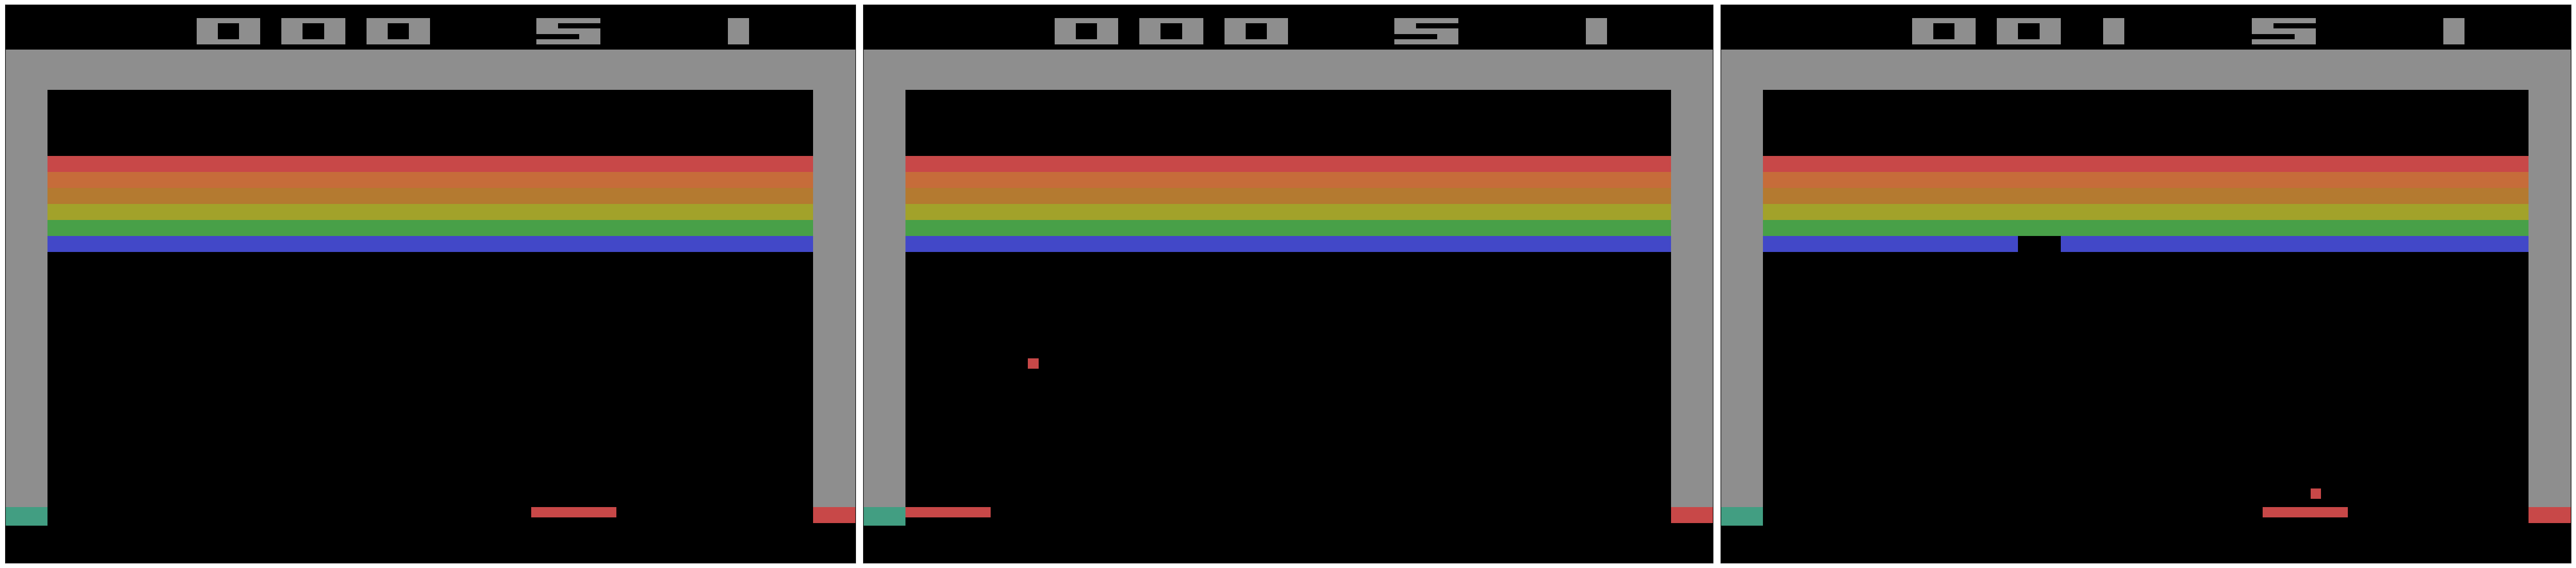

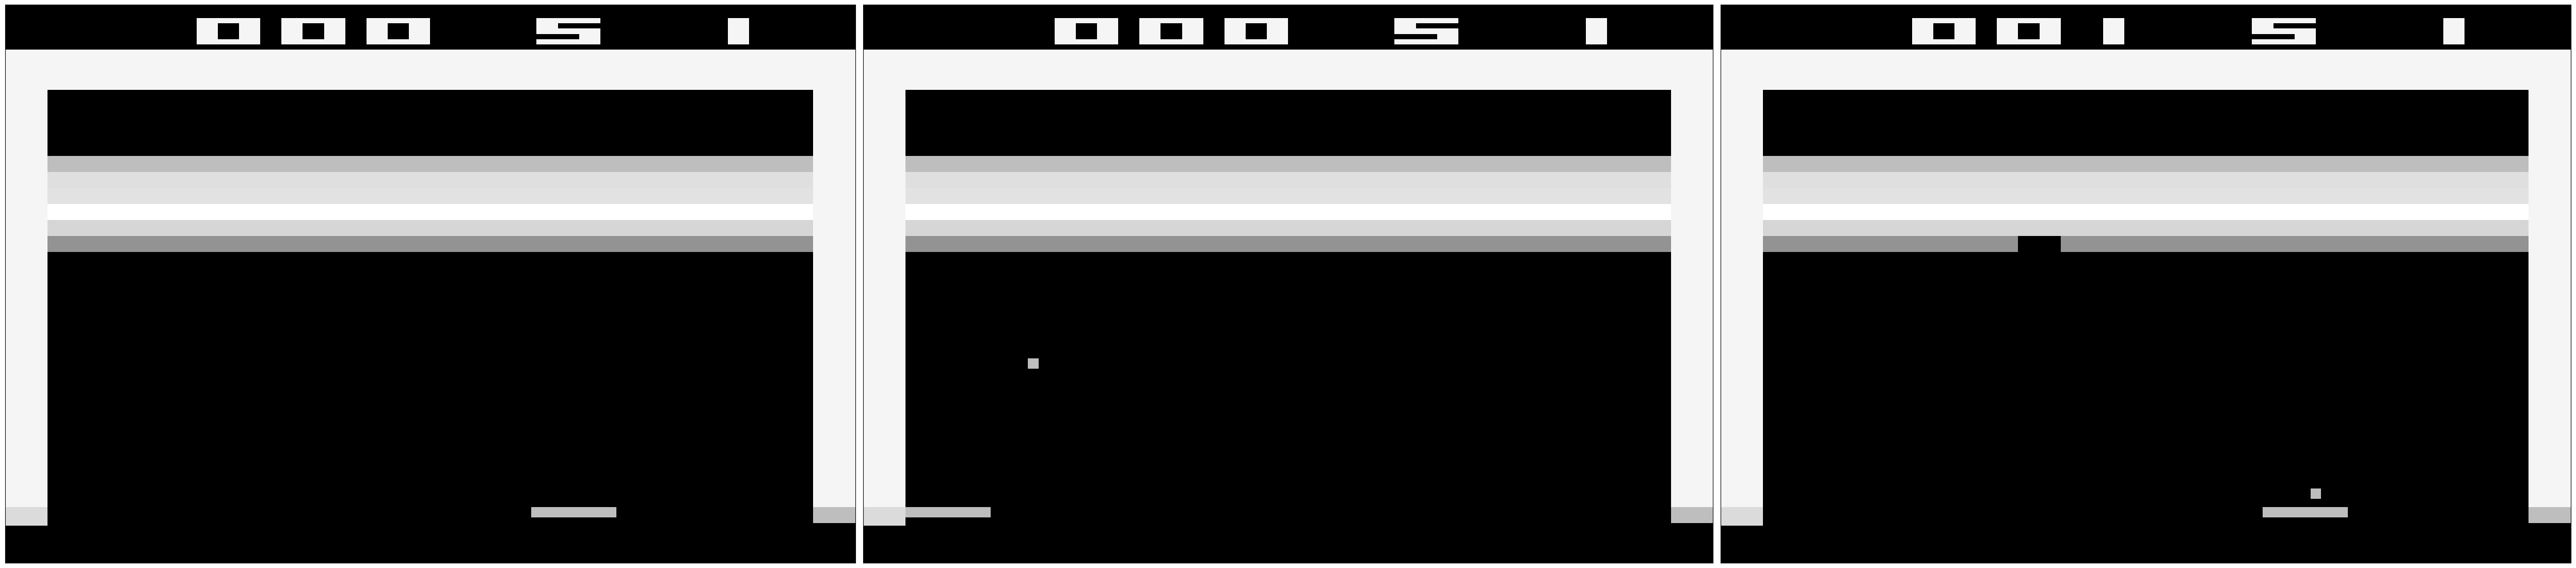

In [58]:
break_imgs, break_gray = load_frames('breakout', step = 100) # Specify game we want to study

show_images(break_imgs, mode = 'rgb')
show_images(break_gray, mode = 'gray')

### Step 1

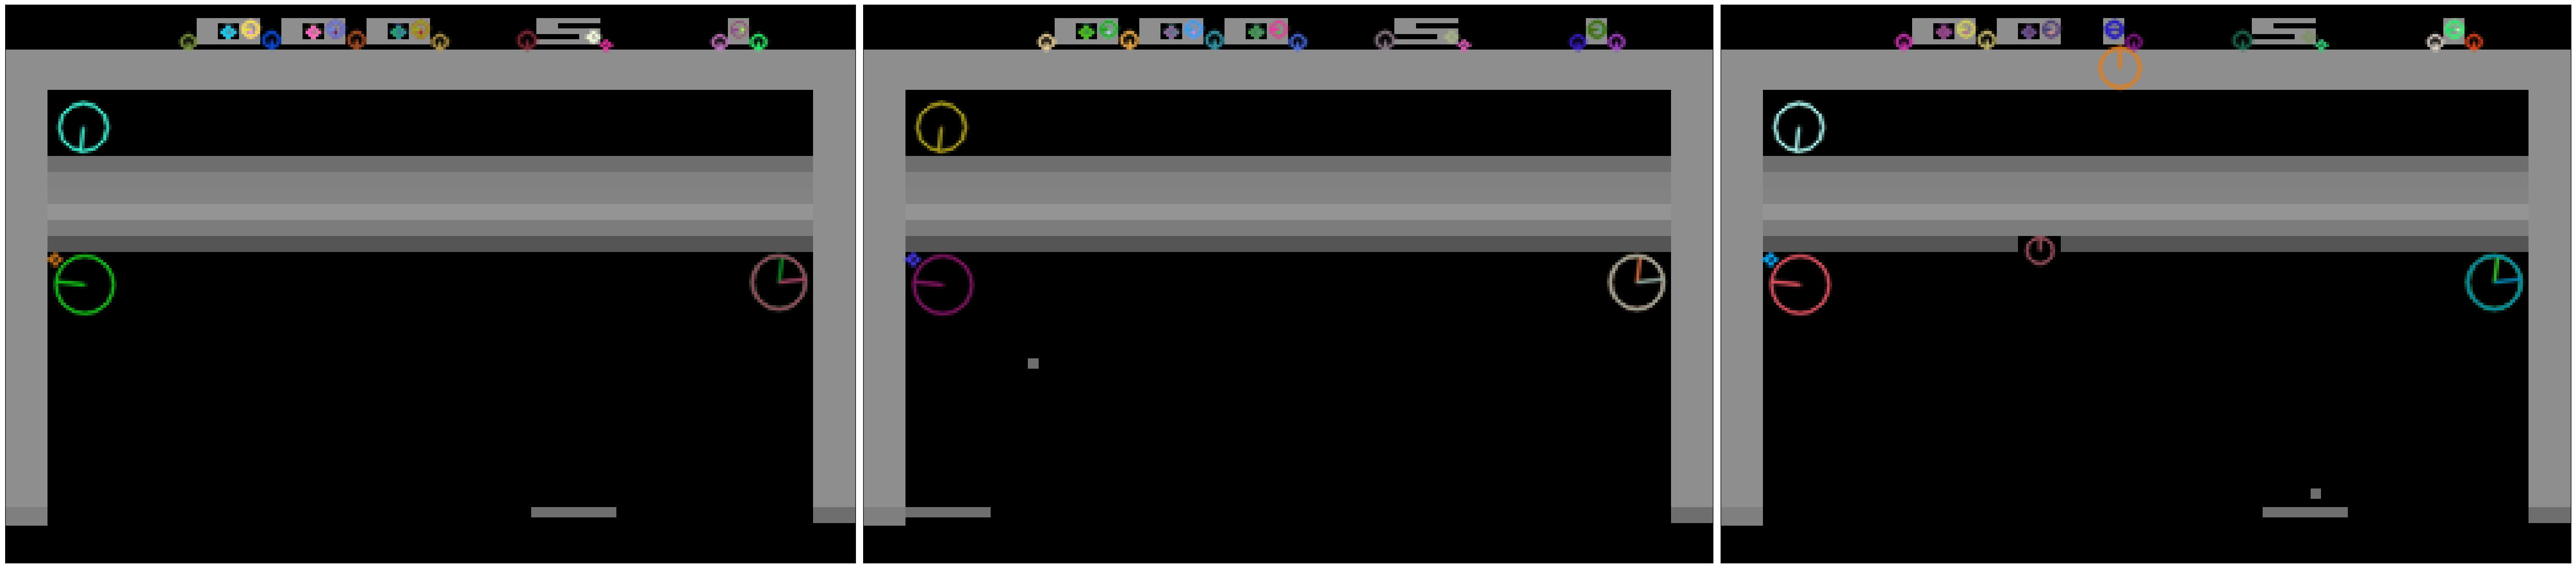

In [59]:
break_kp, break_kp_im = finding_SIFT(break_gray)
# Now we can visualize the frames with the keypoints
show_images(break_kp_im, mode='rgb')
save_images('breakout_step_1', break_kp_im)

### Step 2

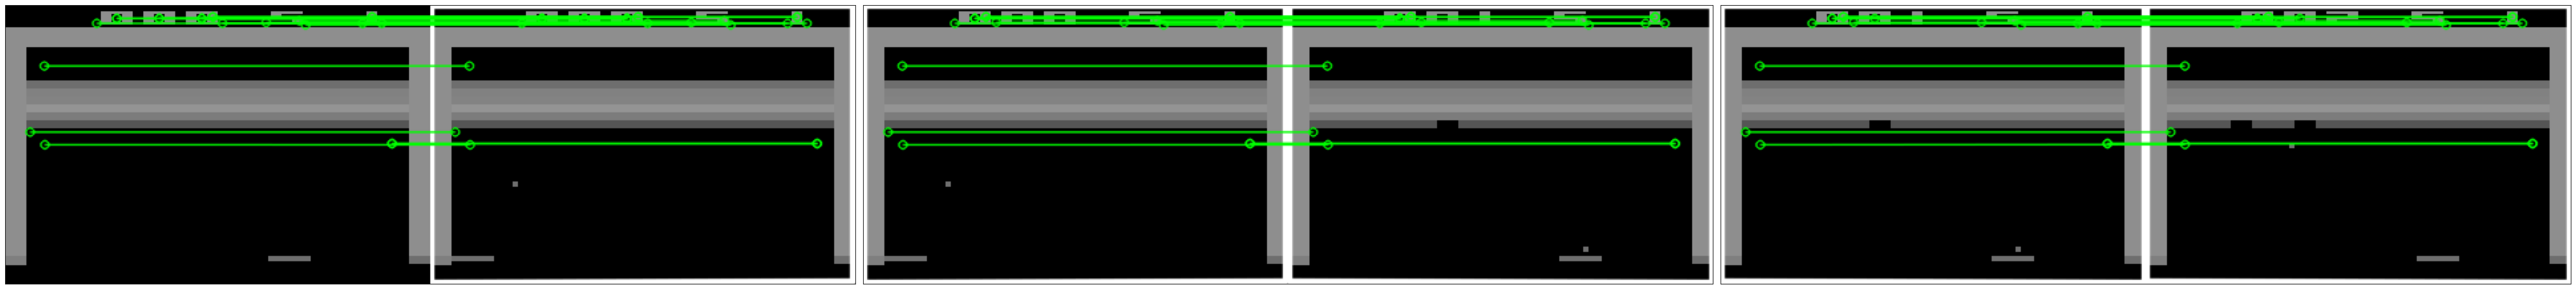

In [60]:
break_good_matches, break_matched_im = find_all_matches(break_gray, break_kp['kps'], break_kp['des'])
show_images(break_matched_im, mode='rgb')
save_images('breakout_step_2', break_matched_im)

### Step 3

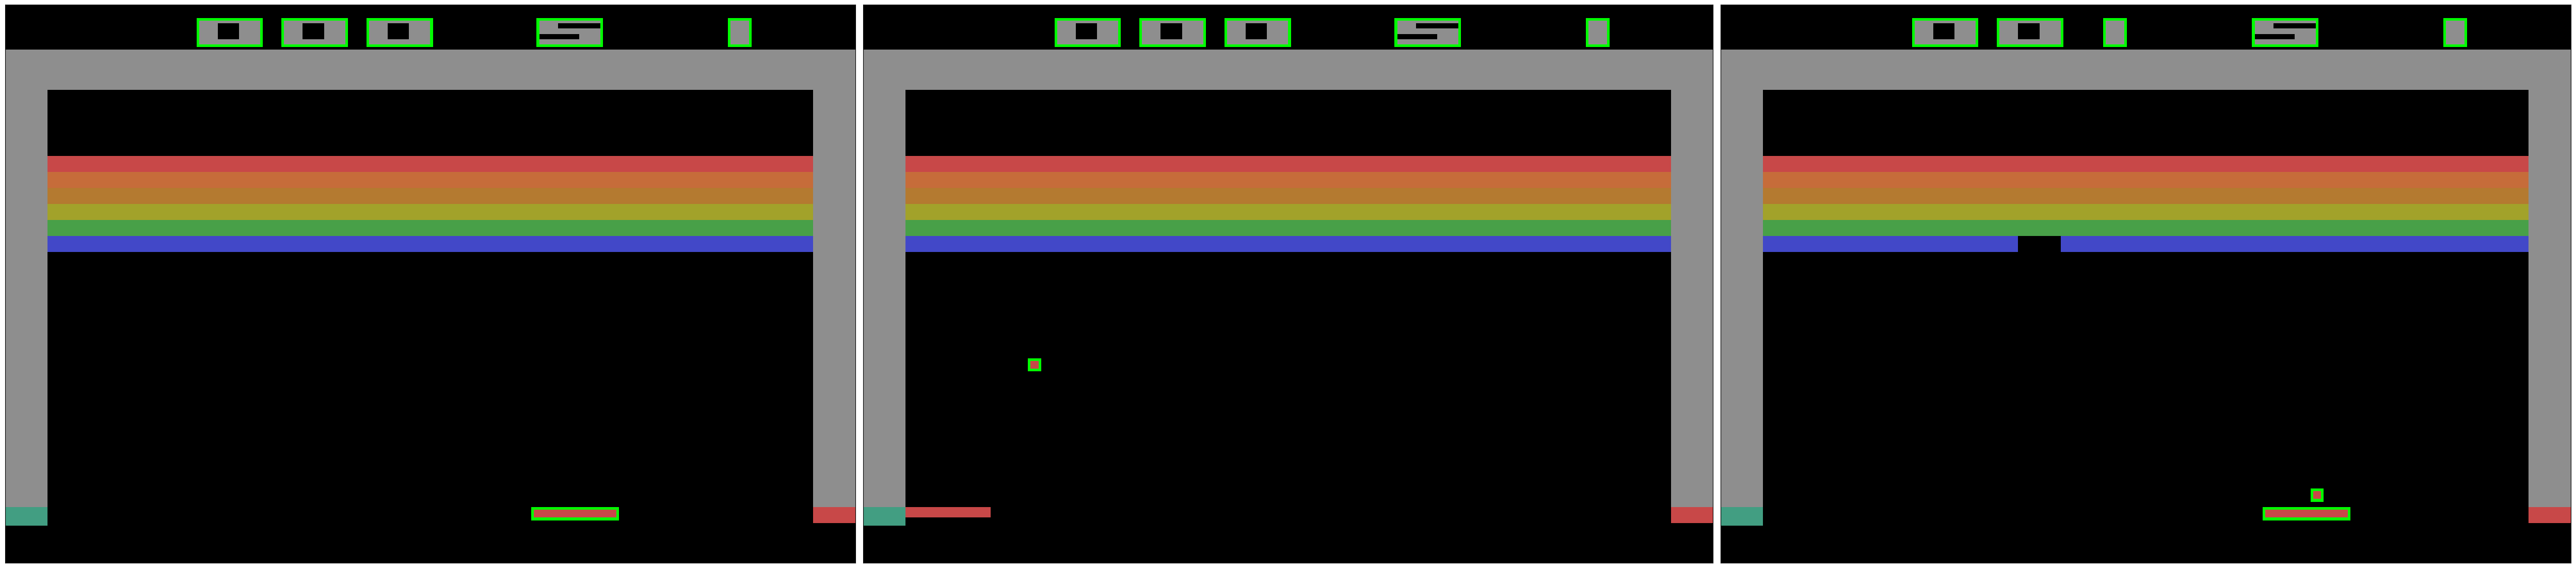

In [61]:
# Highlight object setting them white for better detection
break_high = reverse_and_highlight(break_gray, do_reverse = False, threshold = 60) 

break_obj_info = get_objects(break_high, area_thresh=200)
break_ccs_im = draw_objects(break_imgs, break_obj_info['stats'], break_obj_info['num_labels'])
show_images(break_ccs_im, mode = 'rgb')
save_images("breakout_step_3", break_ccs_im)

### Step 4

In [62]:
break_classes = classify_objects(break_obj_info['stats'], break_obj_info['pixels_lists'], thresh=0.9)

89 7


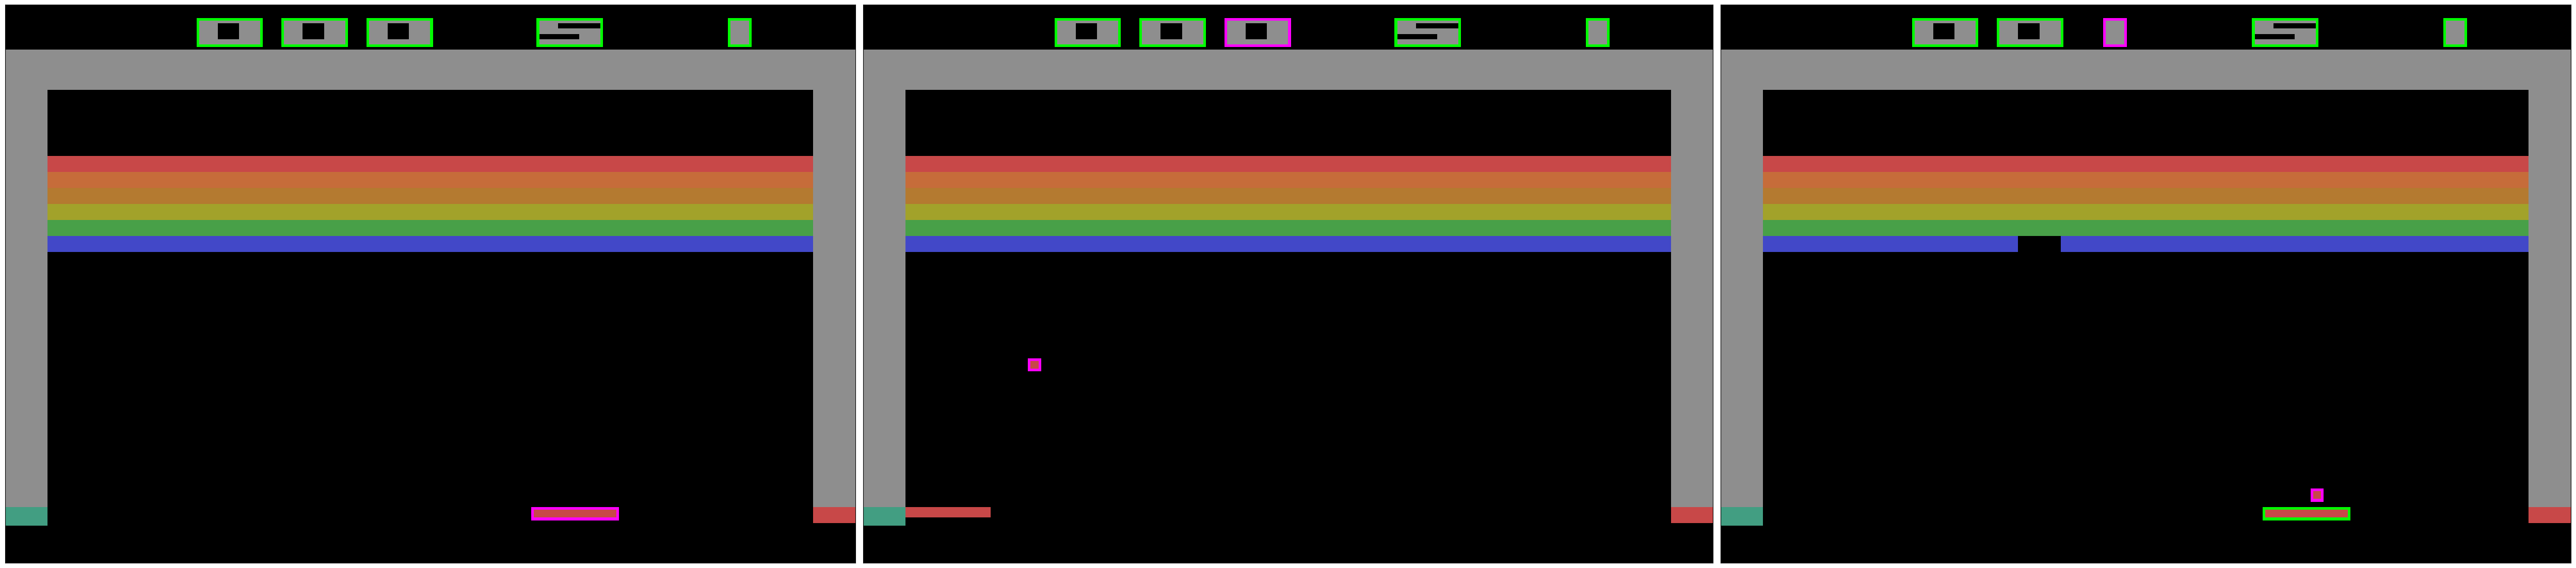

In [63]:
# Let's now draw rectangles around classes of different colours
break_classes_im = draw_classes(break_imgs, break_obj_info['stats'], break_classes, 
                                break_obj_info['num_labels'])
show_images(break_classes_im, mode='rgb')
save_images("breakout_step_4", break_classes_im)

### Step 5

In [64]:
break_mob_ind = get_mobile_index(break_classes)
break_tracking = track_objects(break_obj_info['stats'], break_mob_ind)

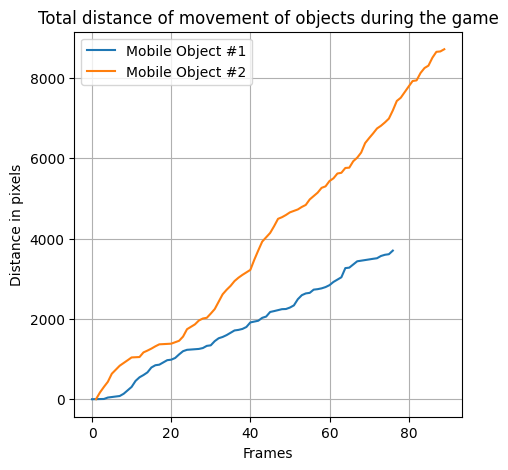

In [65]:
plot_tracking(break_tracking, 'breakout_step_5', min_detections=30)

## Skiing Analysis
After analyzing features of the breakout game we can try to run the algorithm on skiing.

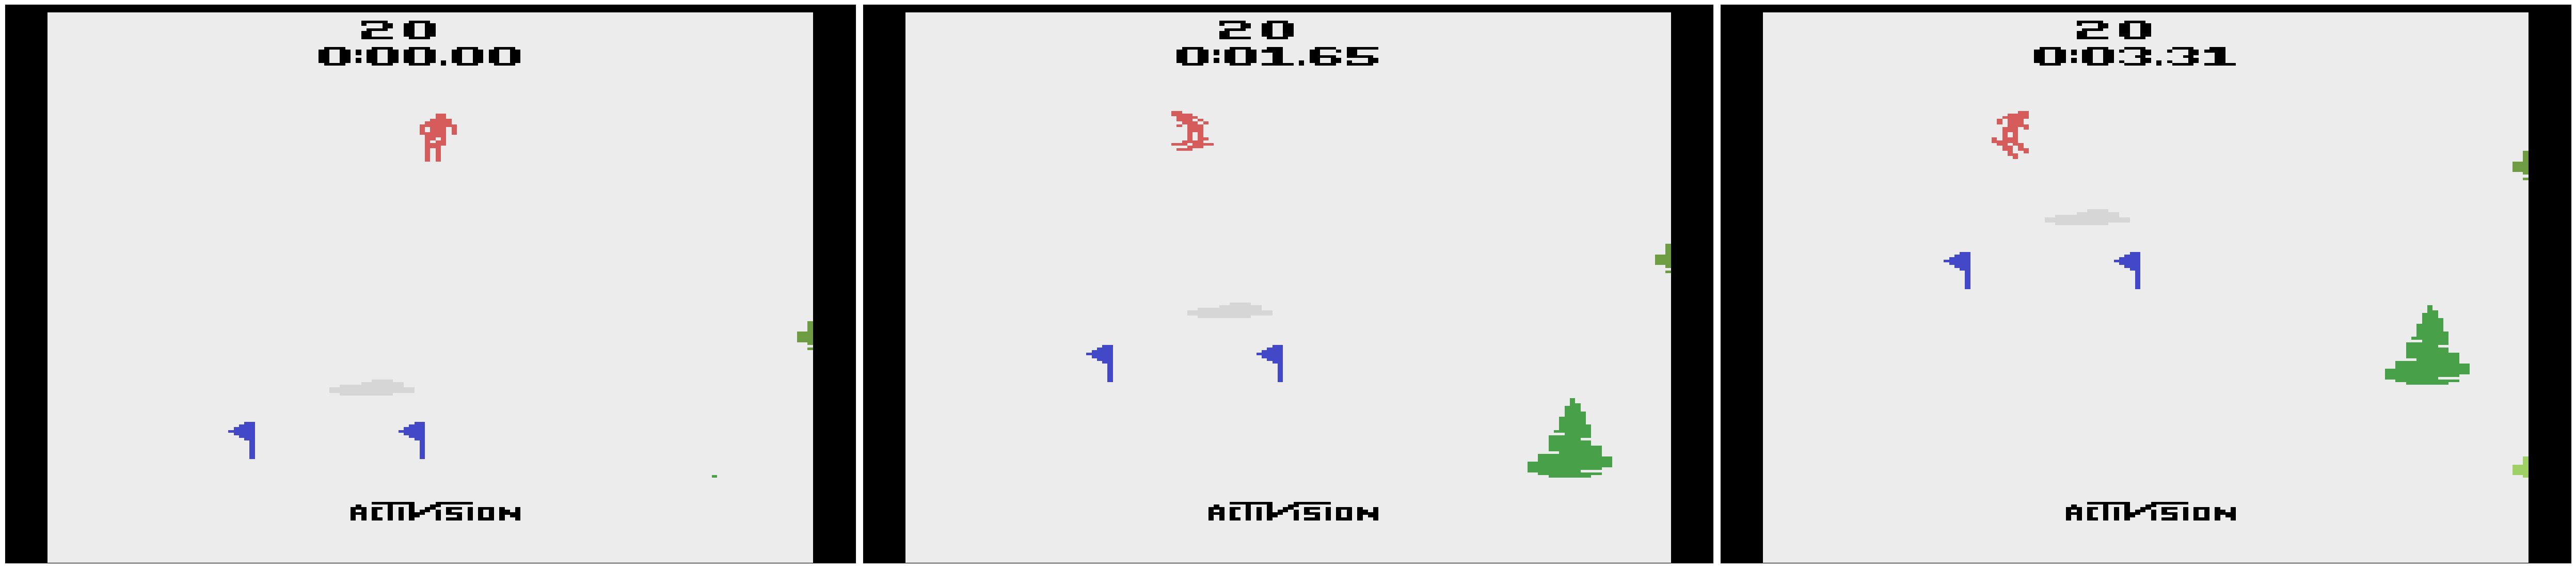

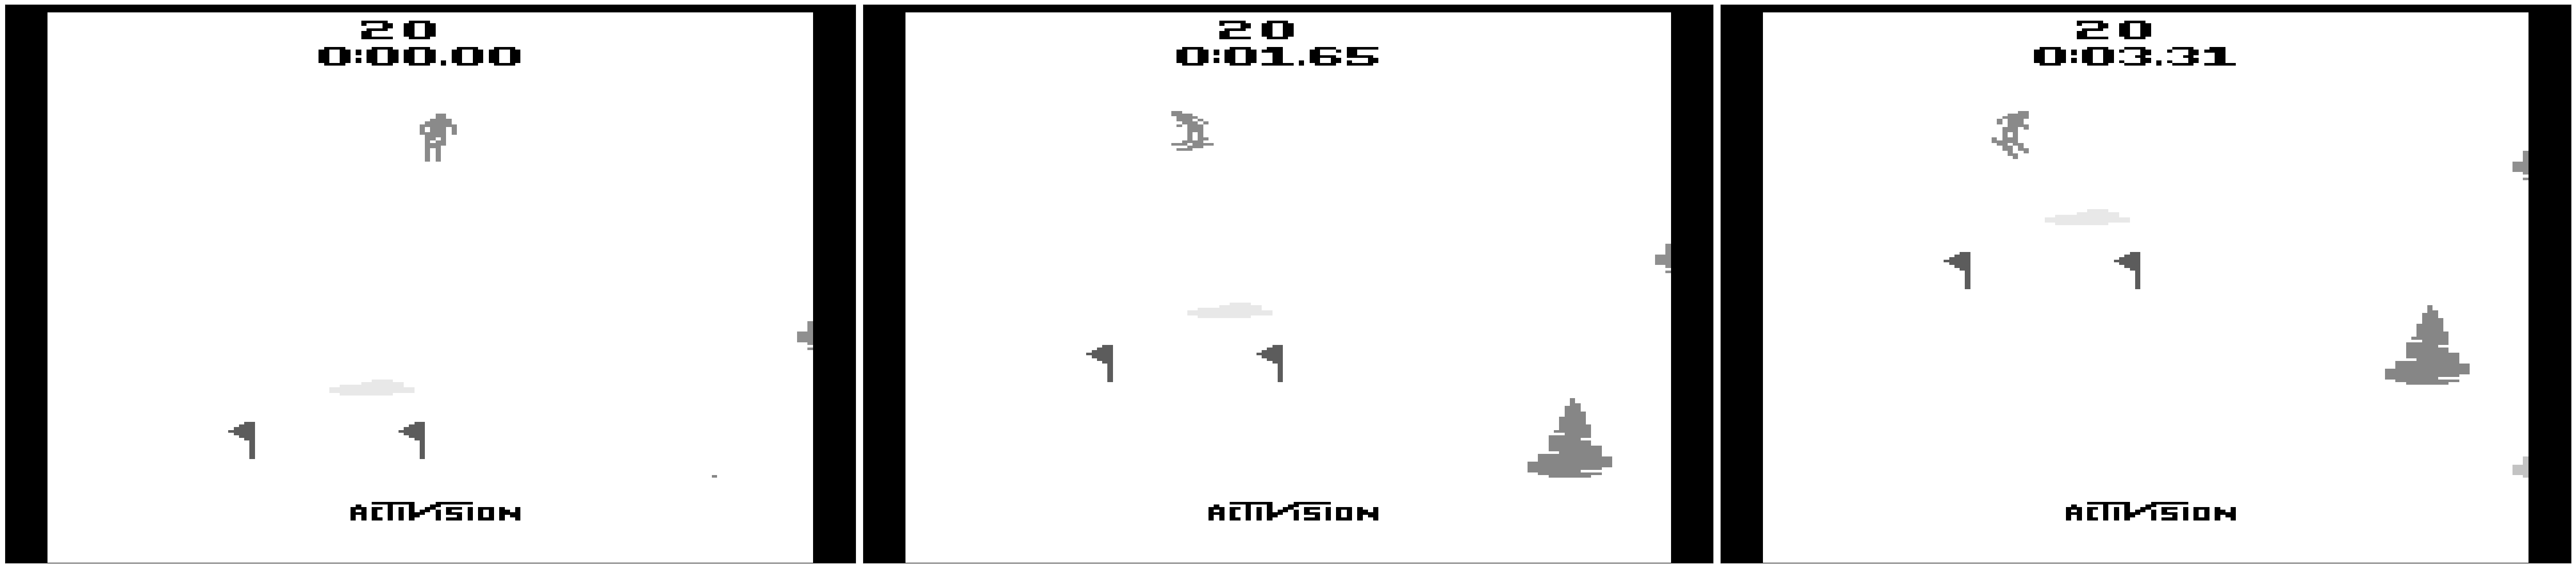

In [66]:
skii_imgs, skii_gray = load_frames('skiing', step = 100) # Specify game we want to study
#skii_gray = reverse_and_highlight(skii_gray)

show_images(skii_imgs, mode = 'rgb')
show_images(skii_gray, mode = 'gray')

### Step 1

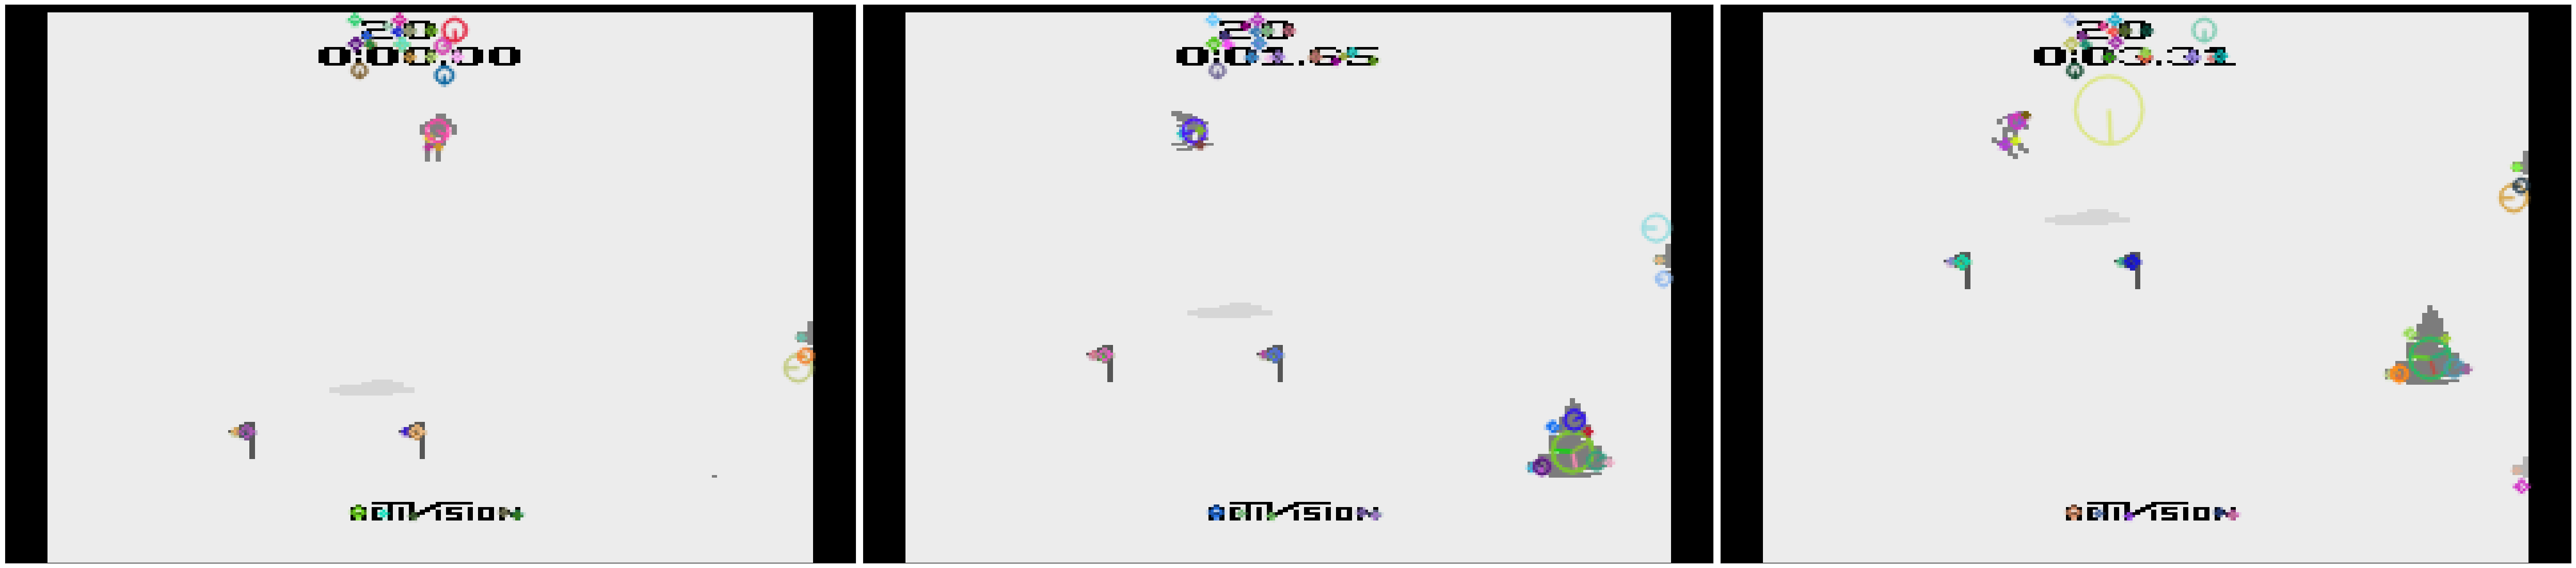

In [67]:
skii_kp, skii_kp_im = finding_SIFT(skii_gray)
# Now we can visualize the frames with the keypoints
show_images(skii_kp_im, mode='rgb')
save_images('skiing_step_1', skii_kp_im)

### Step 2

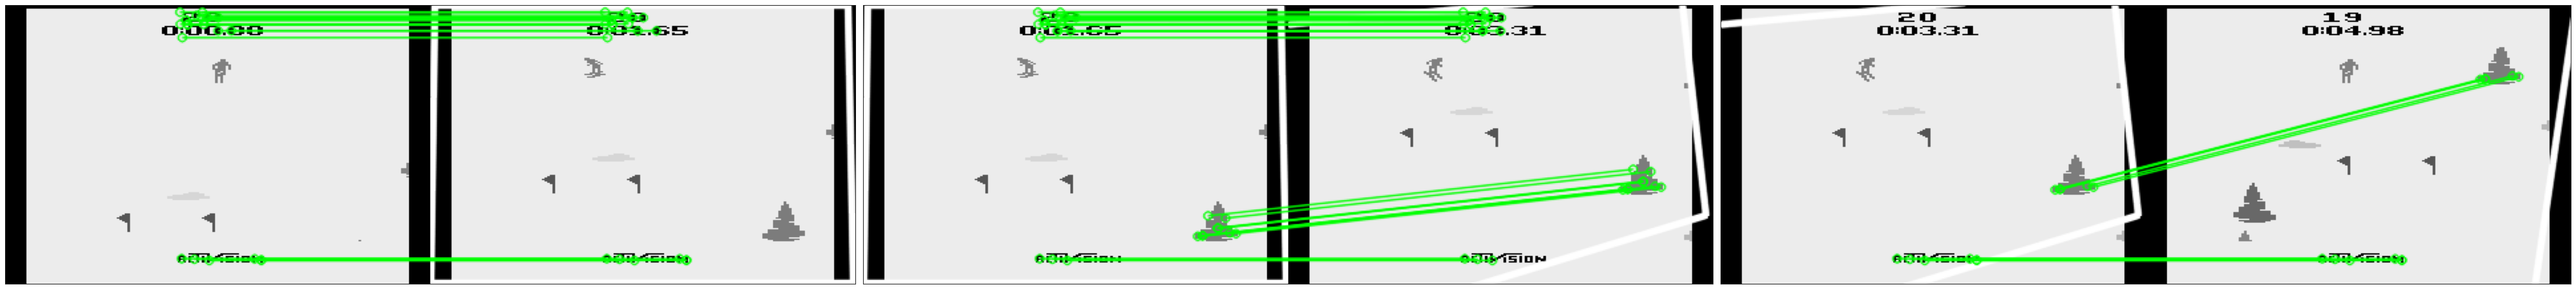

In [68]:
skii_good_matches, skii_matched_im = find_all_matches(skii_gray, skii_kp['kps'], skii_kp['des'])
show_images(skii_matched_im, mode='rgb')
save_images('skiing_step_2', skii_matched_im)

### Step 3

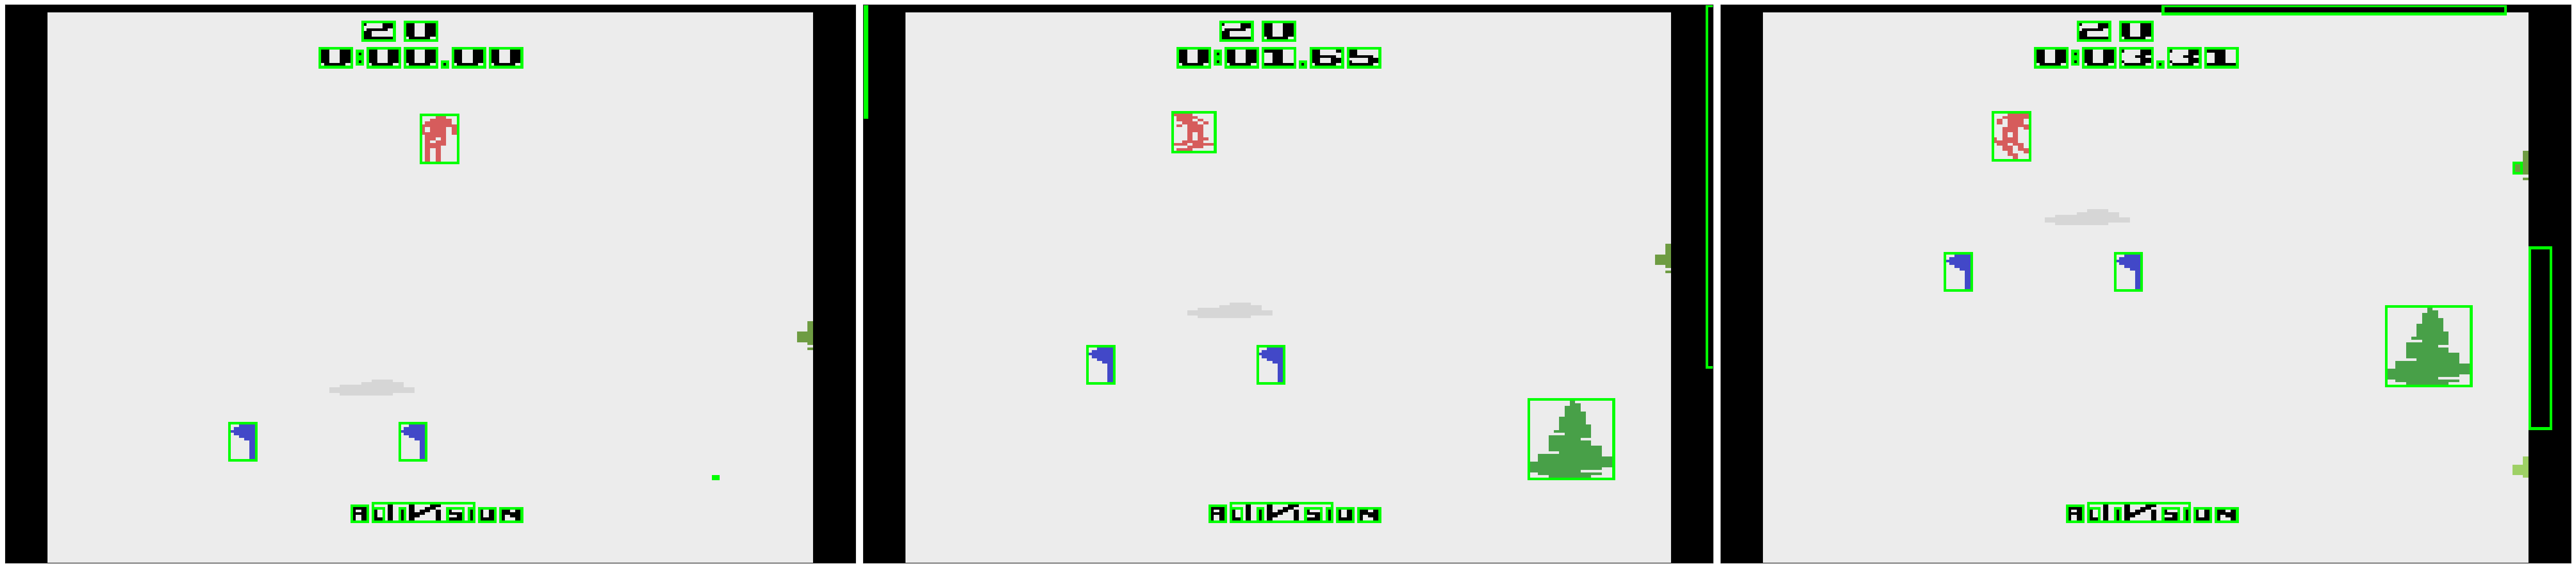

In [69]:
# Reverse and highlight for better detection
skii_high = reverse_and_highlight(skii_gray, do_reverse= True, threshold = 60) 

skii_obj_info = get_objects(skii_high, area_thresh = 500) # Area thresh 500 to find trees
skii_ccs_im = draw_objects(skii_imgs, skii_obj_info['stats'], skii_obj_info['num_labels'])
show_images(skii_ccs_im, mode = 'rgb')
save_images("skiing_step_3", skii_ccs_im)

### Step 4

In [70]:
skii_classes = classify_objects(skii_obj_info['stats'], skii_obj_info['pixels_lists'], thresh=0.9)

21 32


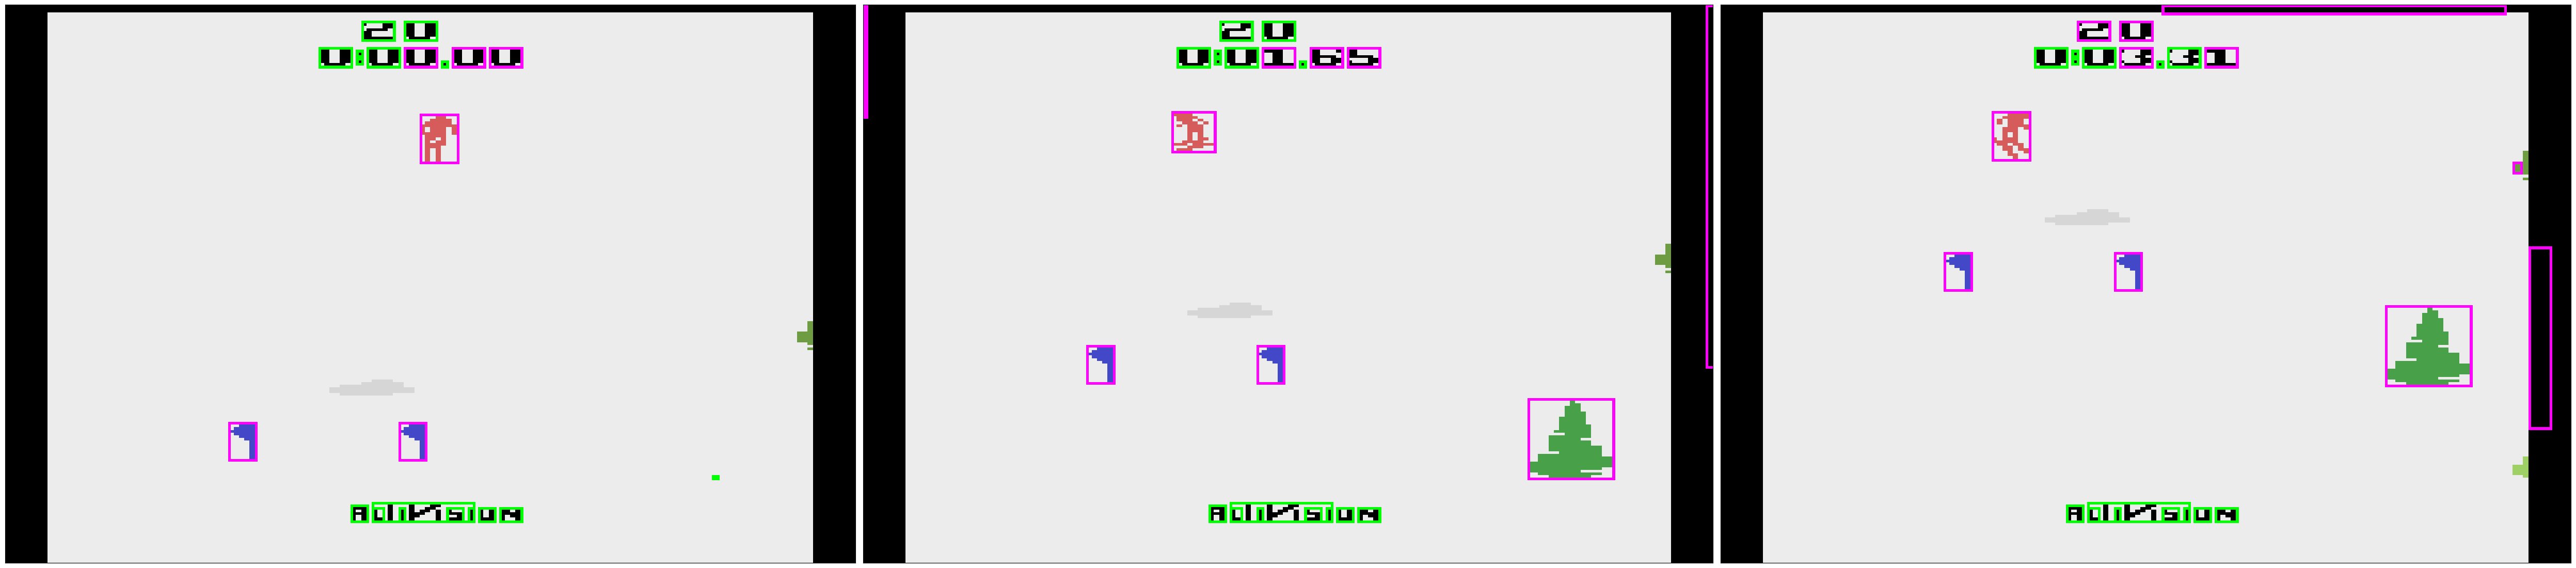

In [71]:
# Let's now draw rectangles around classes of different colours
skii_classes_im = draw_classes(skii_imgs, skii_obj_info['stats'], skii_classes, 
                                skii_obj_info['num_labels'])
show_images(skii_classes_im, mode='rgb')
save_images("skiing_step_4", skii_classes_im)

### Step 5

In [72]:
skii_mob_ind = get_mobile_index(skii_classes)
skii_tracking = track_objects(skii_obj_info['stats'], skii_mob_ind)

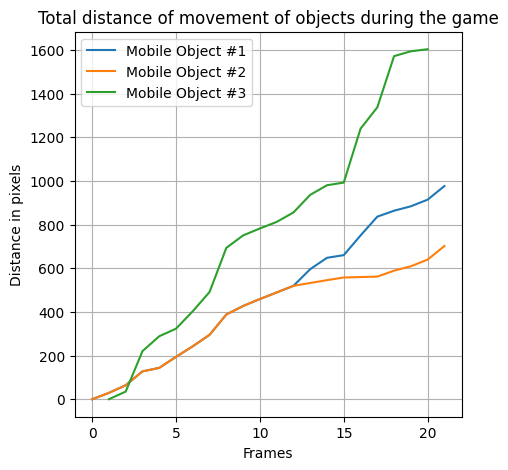

In [73]:
plot_tracking(skii_tracking, 'skiing_step_5', min_detections=16)